In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
# import xgboost as xgb
import lightgbm as lgb
from category_encoders import MEstimateEncoder, TargetEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

In [2]:
# Loading the dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(f"Train data: {train.shape}")
print(f"Test data: {test.shape}")
display(train.head())
display(test.head())

Train data: (614, 13)
Test data: (367, 12)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [3]:
# Checking the data types of the features
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
# Let's combine the train and test data for preprocessing purpose
test["Loan_Status"] = "Test"
data = pd.concat([train, test])
data.shape

(981, 13)

In [5]:
# Checking for missing values in the data
data.isnull().sum()

Loan_ID               0
Gender               24
Married               3
Dependents           25
Education             0
Self_Employed        55
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           27
Loan_Amount_Term     20
Credit_History       79
Property_Area         0
Loan_Status           0
dtype: int64

Before we move to the imputation methodology, it is best to look at the distributions of the features to get a good understanding of the data.

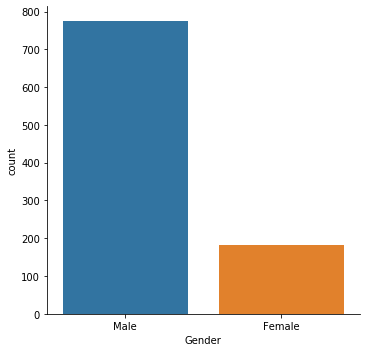

In [6]:
# Distribution of Gender
sns.catplot(x='Gender', kind='count', data=data)

In our dataset, the number of Male applicants who apply for loan is higher compared to Female. So, when imputing the missing values for this feature, one method is to impute Male for all the observations.

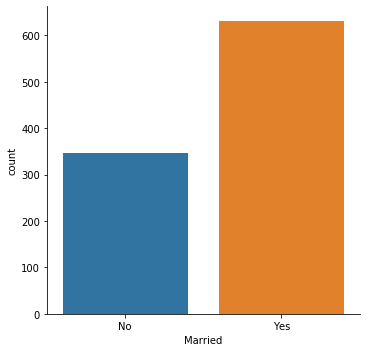

In [7]:
# Distribution of Married
sns.catplot(x='Married', kind='count', data=data)

It is observed that, married people apply for loan more than the unmarried one. This seems logical and inline with reality, as more married people tend to apply for Home loans than bachelors.

Let us dig a little deep into this and check how the approval of the loan is distributed for Married and Unmarried. The Hypothesis is that, Loan Sanction rate for Married people will be more since they are more reliable and trustable(because they have family and so, they tend to default less)

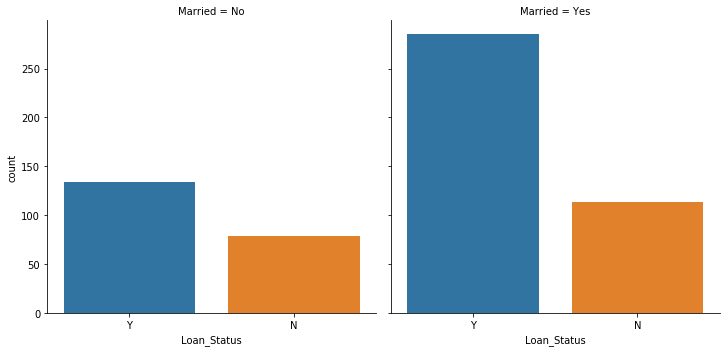

In [8]:
# Approval rate of Married vs Unmarried
sns.catplot(x='Loan_Status', kind='count', data=train, col='Married')

This plot clearly explains that our hypothesis is true. Indeed, the married people approval rate for loan is higher compared to the unmarried.

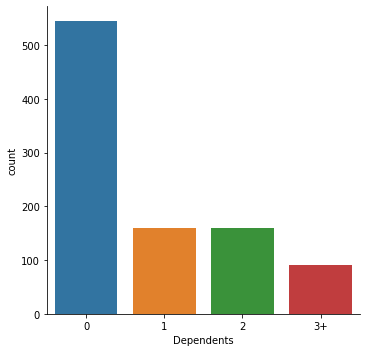

In [9]:
# Distributions of Dependents feature
data['Dependents'].map({'0': 'zero',
                       '1': 'one',
                       '2': 'two',
                       '3+': 'More than 3'})
sns.catplot(x='Dependents', kind='count', data=data)

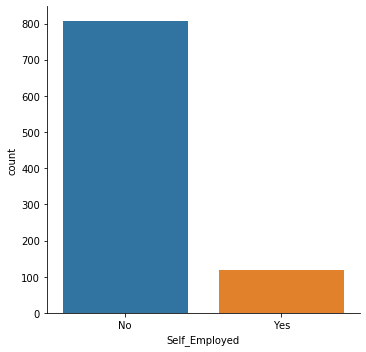

In [10]:
# Distribution of Self-Employed
sns.catplot(x='Self_Employed', kind='count', data=data)

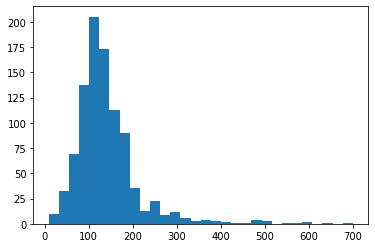

In [11]:
# Distribution of Loan amount
plt.hist(data['LoanAmount'], bins = 30)
plt.show()

In [12]:
# Distribution of Loan amount term
data['Loan_Amount_Term'].value_counts()

360.0    823
180.0     66
480.0     23
300.0     20
240.0      8
84.0       7
120.0      4
36.0       3
60.0       3
12.0       2
350.0      1
6.0        1
Name: Loan_Amount_Term, dtype: int64

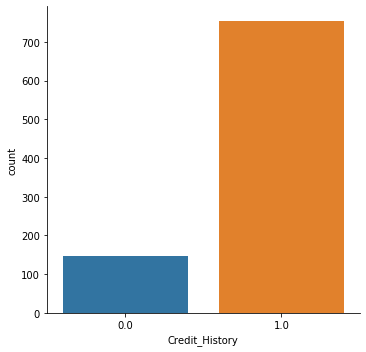

In [13]:
# Distribution of credit history
sns.catplot(x='Credit_History', kind='count', data=data)

The Credit history variable has values 1/0. 1 means the person who applied for the Loan has been properly paying his previous loan dues and has a good credit history whereas 0 means the opposite.

So, now we might have another hypothesis - Applicant who has a score of 1 for credit history will have higher chance of approval for the loan. Let us check this now.

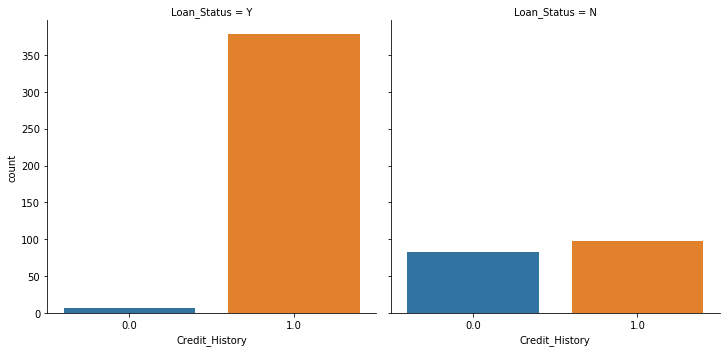

In [14]:
sns.catplot(x='Credit_History', kind='count', data=train, col='Loan_Status')

This validates our hypothesis that People with good credit history tend to have higher loan approval.

Now, let's formulate a methodology to impute the missing values in these features. In the data, except for the **Loan amount** all the other features are categorical. So, we will use simple mode imputation for categorical features and mean imputation for numberical feature.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 13 columns):
Loan_ID              981 non-null object
Gender               957 non-null object
Married              978 non-null object
Dependents           956 non-null object
Education            981 non-null object
Self_Employed        926 non-null object
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Credit_History       902 non-null float64
Property_Area        981 non-null object
Loan_Status          981 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 127.3+ KB


Before moving on to imputation, we have to change Loan_Amount_Term, Credit_History to categorical feature and all the object type to categorical type for better flexibilty provieded by the categorical datatype.

In [16]:
# Converting the object type to category type
col_list = data.select_dtypes(['object']).drop('Loan_Status', axis=1).columns
for col in col_list:
    data[col] = pd.Categorical(data[col])

# Converting the Loan_Amount_term and Credit_History to category type
data['Loan_Amount_Term'] = pd.Categorical(data['Loan_Amount_Term'], ordered=True)
data['Credit_History'] = pd.Categorical(data['Credit_History'])

In [17]:
# Checking the data type
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 13 columns):
Loan_ID              981 non-null category
Gender               957 non-null category
Married              978 non-null category
Dependents           956 non-null category
Education            981 non-null category
Self_Employed        926 non-null category
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null category
Credit_History       902 non-null category
Property_Area        981 non-null category
Loan_Status          981 non-null object
dtypes: category(9), float64(2), int64(1), object(1)
memory usage: 116.7+ KB


In [18]:
# Imputing Category type
for col in data.select_dtypes(['category']):
    data[col] = data[col].fillna(data[col].mode()[0])

# Imputing Numerical type
for col in data.select_dtypes(['int64', 'float64']):
    data[col] = data[col].fillna(np.mean(data[col]))

In [19]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Let's check the distribution of the label.

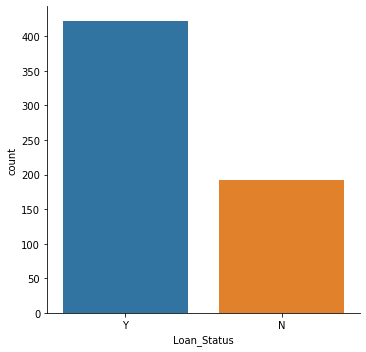

In [20]:
# label distribution
sns.catplot(x='Loan_Status', kind='count', data=train)

So, the data is imbalanced. First will fit some models and check how it is performing and then will try balancing the dataset to see if there is any further improvement in the model.

In [21]:
# Preparing the data
cat_features = data.select_dtypes(['category']).columns[1:]
print(cat_features)
num_features = data.select_dtypes(['int64', 'float64']).columns
print(num_features)

final_features = []
for i in (cat_features, num_features):
    for j in i:
        final_features.append(j)
print(final_features)

train_processed = data.iloc[:train.shape[0], :]
train_processed['Loan_Status'] = train_processed['Loan_Status'].astype('category')

# Encoding the target variable
label = LabelEncoder()
train_processed['Loan_Status'] = label.fit_transform(train_processed['Loan_Status'])

test_processed = data.iloc[train.shape[0]:, :]
test_processed.drop('Loan_Status', axis=1, inplace=True)
print(train_processed.shape)
print(test_processed.shape)

# Encoding the categorical features
encoder = MEstimateEncoder()
train_processed[cat_features]= encoder.fit_transform(train_processed[cat_features], train_processed['Loan_Status'])
test_processed[cat_features] = encoder.transform(test_processed[cat_features])

# Standardizing numerical features
scaler = StandardScaler()
train_processed[num_features]= scaler.fit_transform(train_processed[num_features])
test_processed[num_features] = scaler.transform(test_processed[num_features])


X_train, X_val, y_train, y_val = train_test_split(train_processed[final_features], train_processed['Loan_Status'],stratify=train_processed['Loan_Status'], random_state=123, test_size = 0.2)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], dtype='object')
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
(614, 13)
(367, 12)


In [22]:
# Function to create submission file
def submission(model, test_data, save=False):
    pred_test = model.predict(test_data[final_features])
    sub = test[['Loan_ID']]
    sub['Loan_Status'] = pred_test
    sub['Loan_Status'] = sub['Loan_Status'].map({1:"Y", 0:"N"})
    
    if save:
        sub.to_csv("submission.csv", index=False)
    return sub

In [23]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount
2,0.691227,0.718128,0.686114,0.708290,0.682979,0.697699,0.79028,0.658558,-0.393747,-0.554487,-0.955941
301,0.691227,0.718128,0.686114,0.612498,0.687969,0.697699,0.79028,0.767894,-0.414225,0.044036,-0.491501
117,0.691227,0.718128,0.647449,0.708290,0.687969,0.697699,0.79028,0.658558,-0.522514,-0.076353,-0.729675
380,0.691227,0.718128,0.686114,0.708290,0.687969,0.697699,0.79028,0.767894,-0.339194,0.300545,-0.217601
405,0.669799,0.629380,0.686114,0.708290,0.687969,0.697699,0.79028,0.767894,-0.140310,-0.554487,-0.372414


In [24]:
# Logistic Regression
logit = LogisticRegression()
logit.fit(X_train, y_train)
print(f"Score: {logit.score(X_train, y_train)}")
pred_val = logit.predict(X_val)
print(metrics.accuracy_score(y_val, pred_val))

Score: 0.814663951120163
0.7886178861788617


In [25]:
# Decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(f"Score: {dt.score(X_train, y_train)}")
pred_val = dt.predict(X_val)
print(metrics.accuracy_score(y_val, pred_val))

Score: 0.8268839103869654
0.7886178861788617


In [26]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=2)
rf.fit(X_train, y_train)
print(f"Score: {rf.score(X_train, y_train)}")
pred_val = rf.predict(X_val)
print(metrics.accuracy_score(y_val, pred_val))

Score: 0.8574338085539714
0.7967479674796748


In [27]:
sub = submission(rf, test_processed)
sub.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
